# Predicting climbing ability

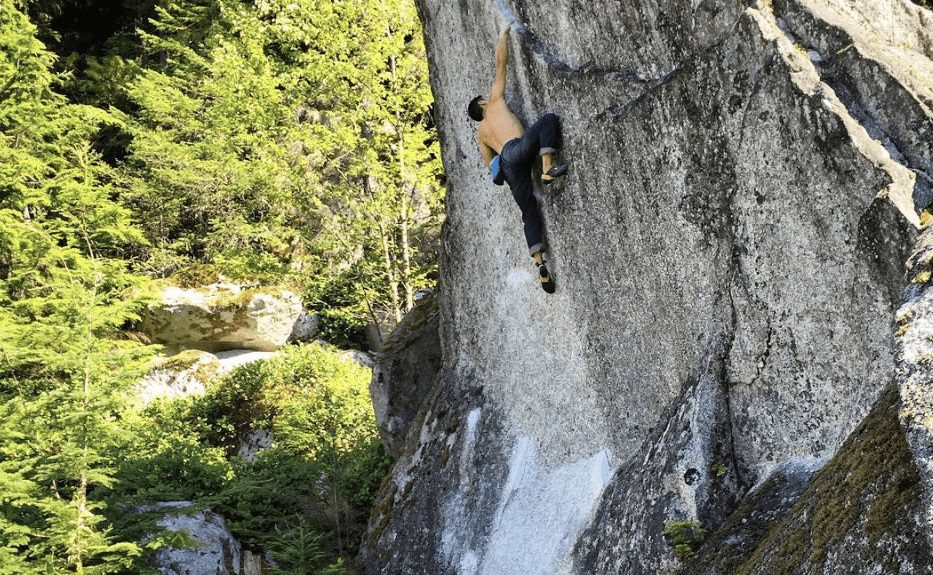
https://gripped.com/profiles/a-beginners-guide-to-outdoor-bouldering/

As someone who enjoys climbing in my free time, I've wondered what traits make a good climber and if these traits could accurately predict climbing ability. To answer this question I downloaded a climbing dataset collected from 8a.nu, a climbing community and logbook climbers use to track their ascents (https://www.kaggle.com/dcohen21/8anu-climbing-logbook). In this project I'll build a model using this data to predict the maximum route difficulty a climber can complete.

In [210]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from xgboost import plot_importance

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.options.mode.chained_assignment = None

## Data exploration

There are 4 tables in this dataset: ascents, users, method, and grade.

In [116]:
ascents = pd.read_csv('ascents.csv', dtype = {'description': object})
user = pd.read_csv('user.csv', dtype = {'worst_area':object})
grades = pd.read_csv('grades.csv')
method = pd.read_csv('method.csv')

The ascents table describes each logged climb:

In [121]:
ascents.head(10)
print("table dimensions:", ascents.shape)
ascents.dtypes

,id,user_id,grade_id,notes,raw_notes,method_id,climb_type,total_score,date,year,...,country,comment,rating,description,yellow_id,climb_try,repeat,exclude_from_ranking,user_recommended,chipped
0,2,1,36,NaN,0,3,0,545,918342000,1999,...,THA,Thailand\n,0,NaN,255,0,0,0,0,0
1,3,1,36,NaN,0,3,0,545,925509600,1999,...,NaN,\n,0,NaN,0,0,0,0,0,0
2,4,1,36,NaN,0,3,0,545,933026400,1999,...,SWE,\n,0,NaN,255,0,0,0,0,0
3,5,1,36,NaN,0,3,0,545,933026400,1999,...,SWE,\n,0,NaN,255,0,0,0,0,0
4,6,1,36,NaN,0,3,0,545,933458400,1999,...,NaN,\n,0,NaN,0,0,0,0,0,0
5,7,1,38,NaN,0,3,0,595,914022000,1998,...,THA,\n,0,NaN,255,0,0,0,0,0
6,8,1,38,NaN,0,3,0,595,915404400,1999,...,NaN,Indonesien\n,0,NaN,0,0,0,0,0,0
7,9,1,38,NaN,0,1,0,450,916268400,1999,...,THA,\n 1-3 RP,0,NaN,255,0,0,0,0,0
8,10,1,38,NaN,0,3,0,595,916441200,1999,...,THA,Thailand\n,0,NaN,0,0,0,0,0,0
9,11,1,38,NaN,0,3,0,595,917478000,1999,...,THA,\n,0,NaN,255,0,0,0,0,0


table dimensions: (4111877, 28)


id                       int64
user_id                  int64
grade_id                 int64
notes                   object
raw_notes                int64
method_id                int64
climb_type               int64
total_score              int64
date                     int64
year                     int64
last_year                int64
rec_date                 int64
project_ascent_date      int64
name                    object
crag_id                  int64
crag                    object
sector_id                int64
sector                  object
country                 object
comment                 object
rating                   int64
description             object
yellow_id                int64
climb_try                int64
repeat                   int64
exclude_from_ranking     int64
user_recommended         int64
chipped                  int64
dtype: object

The users table describes the climbers logging the climbs:

In [122]:
user.head(10)
print("table dimensions:", user.shape)
user.dtypes

,id,first_name,last_name,city,country,sex,height,weight,started,competitions,...,sponsor2,sponsor3,best_area,worst_area,guide_area,interests,birth,presentation,deactivated,anonymous
0,1,first,last,Göteborg,SWE,0,177,73,1996,NaN,...,NaN,NaN,"Railay beach, Krabi, Thailand",NaN,NaN,NaN,1976-03-10,NaN,0,0
1,2,first,last,stockholm,SWE,0,0,0,2000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,3,first,last,Umeå,SWE,0,180,78,1995,NaN,...,NaN,NaN,Hell,Umeå,NaN,NaN,1973-09-09,NaN,0,0
3,4,first,last,Goteborg,SWE,1,165,58,2001,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1984-07-26,NaN,0,0
4,5,first,last,North Attleboro,USA,0,0,0,1991,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1969-05-07,NaN,0,0
5,6,first,last,Sydney,AUS,0,185,73,1992,last,...,NaN,NaN,Sydney,NaN,NaN,NaN,1970-12-02,NaN,0,0
6,10,first,last,Göteborg,SWE,0,167,63,1992,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1965-06-22,NaN,0,0
7,11,first,last,Arkelstorp,SWE,0,175,73,1998,1:a,...,NaN,NaN,Kjugekull,NaN,Kjugekull,"Play go, read books, listen to jazz and eating...",1980-01-09,NaN,0,0
8,12,first,last,stockholm,SWE,0,0,0,2000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
9,13,first,last,norrkoping,SWE,0,0,0,2000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


table dimensions: (62593, 22)


id               int64
first_name      object
last_name       object
city            object
country         object
sex              int64
height           int64
weight           int64
started          int64
competitions    object
occupation      object
sponsor1        object
sponsor2        object
sponsor3        object
best_area       object
worst_area      object
guide_area      object
interests       object
birth           object
presentation    object
deactivated      int64
anonymous        int64
dtype: object

The grade table describes how different climbing difficulty scales (or grades) relate to one another:  

In [103]:
grades.head(10)
print("table dimensions:", grades.shape)

,id,score,fra_routes,fra_routes_input,fra_routes_selector,fra_boulders,fra_boulders_input,fra_boulders_selector,usa_routes,usa_routes_input,usa_routes_selector,usa_boulders,usa_boulders_input,usa_boulders_selector
0,1,0,-,1,1,-,1,1,3/4,1,1,VB,1,1
1,2,0,1,0,0,1,0,0,NaN,0,0,NaN,0,0
2,3,0,1a,0,0,1A,0,0,NaN,0,0,NaN,0,0
3,4,0,1b,0,0,1B,0,0,NaN,0,0,NaN,0,0
4,5,0,1c,0,0,1C,0,0,NaN,0,0,NaN,0,0
5,6,0,1+,0,0,1+,0,0,NaN,0,0,NaN,0,0
6,7,80,2,1,0,2,1,0,5.1,1,0,VB,0,0
7,8,0,2a,0,0,2A,0,0,NaN,0,0,NaN,0,0
8,9,0,2b,0,0,2B,0,0,NaN,0,0,NaN,0,0
9,10,0,2c,0,0,2C,0,0,NaN,0,0,NaN,0,0


table dimensions: (83, 14)


The method table describes how the climbs were completed. Since I am more familiar with bouldering, I will focus on this climbing style and disregard any toprope climbs. For anyone not familiar, bouldering is a style of climbing without a rope or harness on shorter routes. Bouldering routes typically require more power than endurance compared to toprope.
- redpoint: completed after having practiced the route
- flash: completed on first try but have seen others do it or were told how to do it
- onsight: completed first try without seeing any else do it or being told how to do it


In [104]:
method.head(10)
print("table dimensions:", method.shape)

,id,score,shorthand,name
0,1,0,redpoint,Redpoint
1,2,53,flash,Flash
2,3,145,onsight,Onsight
3,4,-52,toprope,Toprope
4,5,95,onsight,Onsight


table dimensions: (5, 4)


Many of the columns across all of the tables contain missing or inconsistent information. This is a wild caught dataset that will require cleaning and feature engineering before I can build a quality model. 

## Data cleaning and feature engineering

The data was directly entered by users there are likely to be data quality issues I will need to account for. Also, this dataset is subject to self selection bias as the users that take the time to track their stats are more likely to be experienced climbers who are seriously invested in their sport.

To get a sense of the data before I start removing rows, I'll count the number unique climbers and ascents.

In [158]:
user['id'].nunique()
ascents['id'].nunique()

62593

4111877

With 62593 climbers and 4111877 climbs, I have some room to quality filter the data.

One important feature I want to include in the model is age. First, I will filter the user table to only include climbers that have age data.

In [159]:
user_clean = user[user['birth'].notna()]
user_clean['birth'].sort_values()

20018    1000-01-01
59280    1900-01-01
62234    1900-01-01
58524    1900-01-01
58639    1900-01-01
            ...    
52916    2015-10-26
57571    2015-11-22
55904    2016-03-04
60460    2016-09-11
61483    2017-08-20
Name: birth, Length: 27856, dtype: object

There are users who are over 100 years old (with one climber over 1000 years old!). These are most likley a typos so I
will filter to users to those born after 1940.

In [160]:
user_clean = user_clean[user_clean['birth'] > '1940-01-01']
user_clean['birth'].sort_values()

40932    1940-03-10
12130    1940-12-25
3580     1941-04-28
1496     1941-05-26
3786     1941-08-19
            ...    
52916    2015-10-26
57571    2015-11-22
55904    2016-03-04
60460    2016-09-11
61483    2017-08-20
Name: birth, Length: 27725, dtype: object

Next, I'll look at the weight distribution to see if it requires any attention.

count    27725.000000
mean        57.451614
std         26.796627
min          0.000000
25%         53.000000
50%         68.000000
75%         73.000000
max        100.000000
Name: weight, dtype: float64

<AxesSubplot:xlabel='weight', ylabel='Count'>

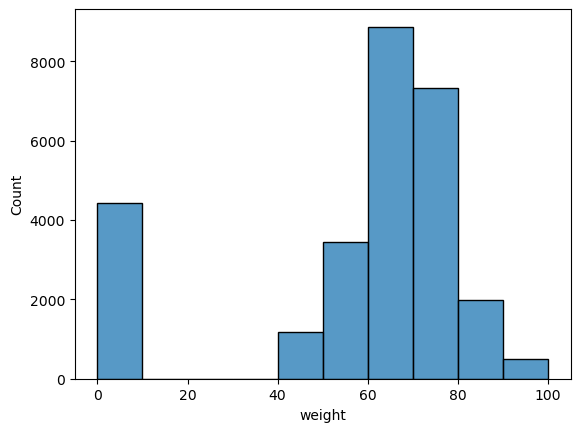

In [161]:
user_clean['weight'].describe()
sns.histplot(user_clean['weight'], bins=10)

The bin to the left that contains weights of 0-10 kg are not likely to be all 0, so I will remove these points.

In [162]:
user_clean = user_clean[user_clean['weight'] > 20]

Now I'll check the height data.

count    23307.000000
mean       160.821127
std         50.498805
min          0.000000
25%        170.000000
50%        176.000000
75%        181.000000
max        255.000000
Name: height, dtype: float64

<AxesSubplot:xlabel='height', ylabel='Count'>

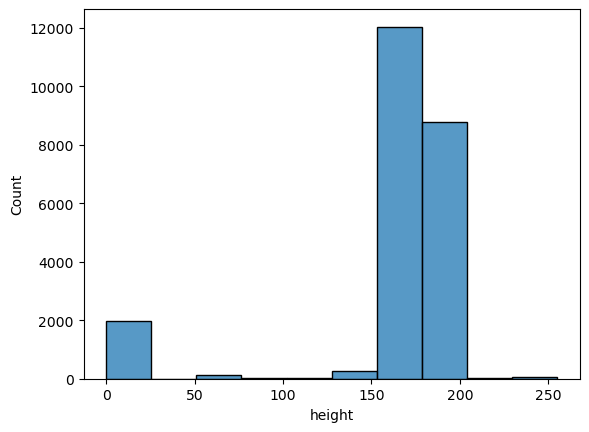

In [163]:
user_clean['height'].describe()
sns.histplot(user_clean['height'], bins=10)

There appears be a large number of climbers with a height of 0. Height also has some extreme nonzero values on either end of the range that are unlikely to be real. I will filter height to be between 4-7.5 feet, and convert height to meters.

count    21103.000000
mean         1.762241
std          0.088953
min          1.210000
25%          1.710000
50%          1.770000
75%          1.820000
max          2.250000
Name: height, dtype: float64

<AxesSubplot:xlabel='height', ylabel='Count'>

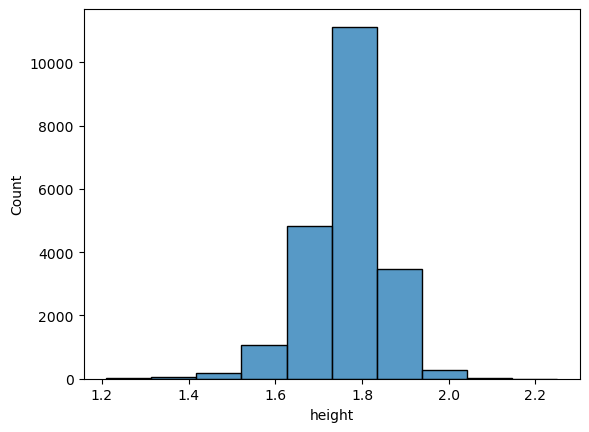

In [164]:
user_clean = user_clean[user_clean['height'] > 120]
user_clean = user_clean[user_clean['height'] < 228]
user_clean['height'] = user_clean['height']/100

Instead of separately using height and weight as potentially highly correlated features in my model, I will calculate BMI for each user.

count    21103.000000
mean        21.936750
std          2.573341
min          8.493827
25%         20.436158
50%         21.799308
75%         23.291230
max         66.935319
Name: bmi, dtype: float64

<AxesSubplot:xlabel='bmi', ylabel='Count'>

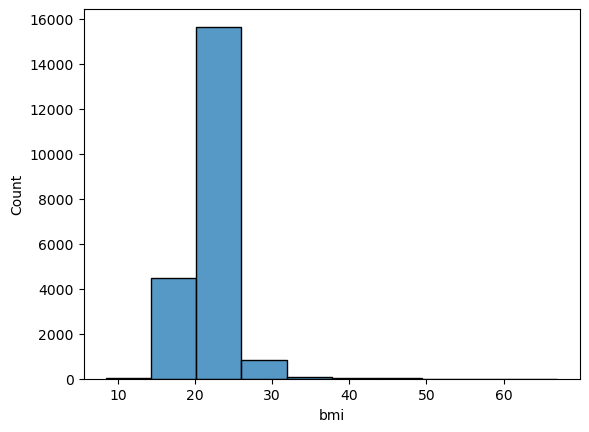

In [166]:
user_clean['bmi'] = user_clean['weight']/(user_clean['height']**2)
user_clean['bmi'].describe()
sns.histplot(user_clean['bmi'], bins=10)

Some of BMI values are physiologically extreme and are more likely to be data entry errors. I will filter BMIs to be between 15-40 to remove any outliers.

In [167]:
user_clean = user_clean[user_clean['bmi'] > 15]
user_clean = user_clean[user_clean['bmi'] < 40]

Now I'll look at the type of climbs the users are recording. 

In [170]:
ascents.groupby(['climb_type']).size()

climb_type
0    2875675
1    1236202
dtype: int64

There are many more sport climbs (0) than bouldering ascents (1) logged. Since I am focusing on bouldering for this model, I will filter to the 1.2 million boulder ascents logged, and then merge the user data with the ascent data.

In [172]:
ascents_bouldering = ascents.loc[ascents['climb_type'] == 1]

user_ascent = pd.merge(user_clean, ascents_bouldering, 
                       left_on='id', right_on='user_id', how='inner', 
                       suffixes=('_user', '_ascents'))

In [173]:
user_ascent['id_user'].nunique()
user_ascent['id_ascents'].nunique()

9469

739554

After cleaning and merging we have 9469 climbers with 739554 climbs.

How many ascents does each climber have?

<AxesSubplot:xlabel='ascent_count', ylabel='Count'>

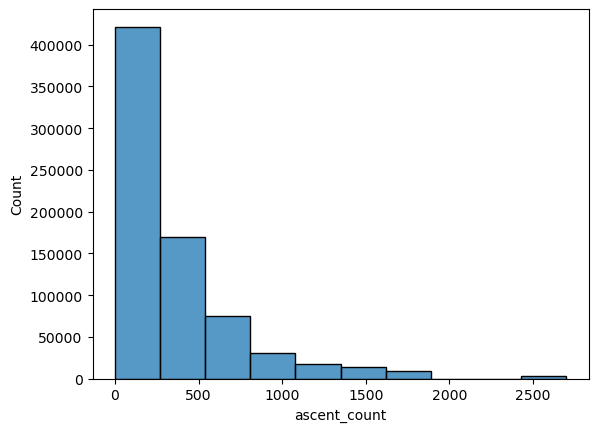

In [175]:
user_ascent['ascent_count'] = user_ascent.groupby(
    'id_user')['id_user'].transform('count')
sns.histplot(user_ascent['ascent_count'], bins=10)

The number of ascents per climber is skewed right. There are a few extreme climbers that are logging many more climbs than most of the other climbers. 

Now I'll calculate age as another feature to use in the model. Age will be different for a climber at each ascent. First, I will need to clean the ascent data.

In [176]:
user_ascent['year'].describe()

count    739554.000000
mean       2010.991734
std          12.352945
min           0.000000
25%        2008.000000
50%        2011.000000
75%        2014.000000
max        2017.000000
Name: year, dtype: float64

Some of the ascents were completed at year 0, so I'll filter include those only completed after the year 1900.

In [177]:
user_ascent = user_ascent[user_ascent['year'] > 1900]

Birth year will need to converted to a pandas datatime object so I can determine age of the climbers at each ascent.

In [178]:
user_ascent['birth'] = pd.to_datetime(user_ascent['birth'])
user_ascent['birth_year'] = user_ascent['birth'].dt.year

user_ascent['ascent_age'] = user_ascent['year'] - user_ascent['birth_year']
user_ascent['ascent_age'].describe()
user_ascent[['id_user','birth_year', 
             'year', 'ascent_age']].sort_values('ascent_age')


count    739527.000000
mean         27.366561
std           6.909296
min          -5.000000
25%          23.000000
50%          27.000000
75%          31.000000
max          72.000000
Name: ascent_age, dtype: float64

,id_user,birth_year,year,ascent_age
532542,33286,2013,2008,-5
532632,33286,2013,2009,-4
532560,33286,2013,2009,-4
532540,33286,2013,2009,-4
532571,33286,2013,2009,-4
...,...,...,...,...
709674,57825,1951,2017,66
738920,66364,1949,2017,68
628035,43325,1940,2012,72
628036,43325,1940,2012,72


Several climbers completed climbs before they were born, so I will remove any rows where ascent age is less than 5.

<AxesSubplot:xlabel='ascent_age', ylabel='Count'>

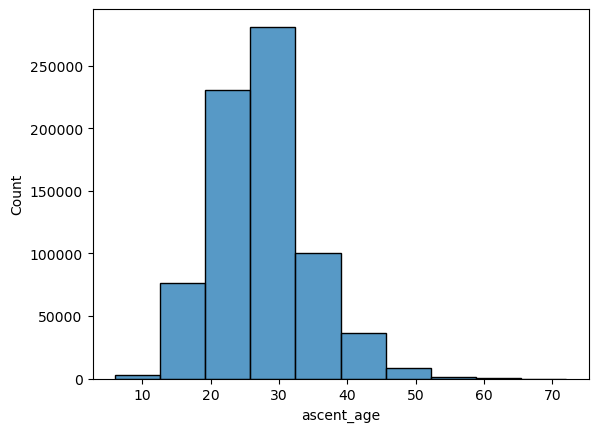

In [179]:
user_ascent = user_ascent[user_ascent['ascent_age'] > 5]

sns.histplot(user_ascent['ascent_age'], bins=10)

Most of the climbers in this dataset were 20-30 years old when they completed their ascents. 

I'll now calculate years of climbing experience at each ascent. This value will also be different at each 
ascent. I'll first check the started column and remove any climbers that started climbing before 1900.

In [188]:
user_ascent = user_ascent[user_ascent['started'] > 1900]
user_ascent['years_exp'] = user_ascent['year'] - user_ascent['started']
user_ascent['years_exp'].describe()

count    681349.000000
mean          8.935893
std           6.399290
min           1.000000
25%           4.000000
50%           7.000000
75%          12.000000
max          69.000000
Name: years_exp, dtype: float64

Some climbers have negative climbing experience, so I will remove these rows.

count    681349.000000
mean          8.935893
std           6.399290
min           1.000000
25%           4.000000
50%           7.000000
75%          12.000000
max          69.000000
Name: years_exp, dtype: float64

<AxesSubplot:xlabel='years_exp', ylabel='Count'>

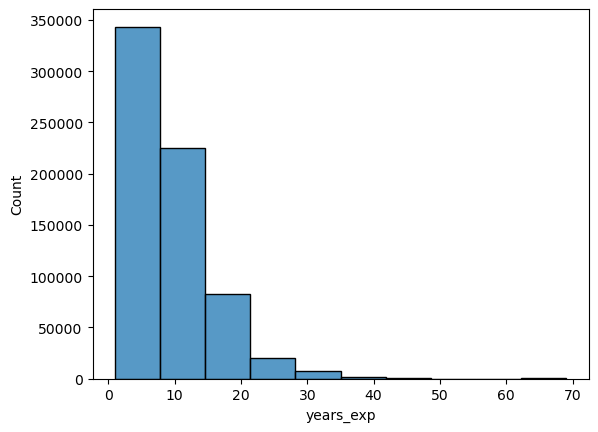

In [189]:
user_ascent = user_ascent[user_ascent['years_exp'] > 0]
user_ascent['years_exp'].describe()
sns.histplot(user_ascent['years_exp'], bins=10)

There still looks there are some extreme values, such as climbers that have 100 years of experience. I'll remove ascents where years of experience is greater than ascent age.

In [190]:
user_ascent[['id_user','birth_year', 'year', 
             'ascent_age', 'years_exp']].sort_values('ascent_age')
user_ascent = user_ascent[user_ascent['years_exp'] < user_ascent['ascent_age']]

,id_user,birth_year,year,ascent_age,years_exp
112644,5323,2000,2006,6,7
345854,19475,2000,2006,6,3
482825,28800,2004,2010,6,6
112676,5323,2000,2006,6,7
112675,5323,2000,2006,6,7
...,...,...,...,...,...
709660,57825,1951,2017,66,49
709661,57825,1951,2017,66,49
709662,57825,1951,2017,66,49
709664,57825,1951,2017,66,49


Next, I will merge in methods and grades tables.

In [216]:
user_ascent_grade = pd.merge(user_ascent, grades[['id', 'usa_boulders']], 
                             left_on='grade_id', right_on='id', how='inner', 
                             suffixes=('_ascents', '_grades'))

user_ascent_grade_method = pd.merge(user_ascent_grade, 
                                    method[['id', 'name']], left_on='method_id',
                                    right_on='id', how='inner', 
                                    suffixes=('_grades','_methods'))

I'm going to clean up the grades (climbing route difficulty) column. I'll condense some of the grades and convert them to integers.

In [217]:
user_ascent_grade_method = user_ascent_grade_method[user_ascent_grade_method['usa_boulders'].notna()]

#convert grades with multiple grades into one grade using the lower grade
user_ascent_grade_method['usa_boulders_new'] = np.where(user_ascent_grade_method['usa_boulders'] == 'V0-',
             'VB', np.where(user_ascent_grade_method['usa_boulders'] == 'V3/4',
                      'V3', np.where(user_ascent_grade_method['usa_boulders'] == 'V4/V5',
                               'V4', np.where(user_ascent_grade_method['usa_boulders'] == 'V5/V6',
                                        'V5', np.where(user_ascent_grade_method['usa_boulders'] == 'V8/9',
                                                 'V8', user_ascent_grade_method['usa_boulders'])))))

#create integer version of grades
user_ascent_grade_method['usa_boulders_numeric'] = user_ascent_grade_method['usa_boulders_new'].str.replace("V", "")
user_ascent_grade_method['usa_boulders_numeric'] = user_ascent_grade_method['usa_boulders_numeric'].str.replace("B", "-1")
user_ascent_grade_method['usa_boulders_numeric']  = user_ascent_grade_method['usa_boulders_numeric'].astype(int)


user_ascent_grade_method['usa_boulders'].unique()
user_ascent_grade_method['usa_boulders_new'].unique()
user_ascent_grade_method['usa_boulders_numeric'].unique()

array(['V5', 'V3/4', 'V3', 'V4', 'V1', 'V0', 'V2', 'VB', 'V7', 'V6',
       'V4/V5', 'V5/V6', 'V8/9', 'V9', 'V11', 'V10', 'V8', 'V12', 'V13',
       'V14', 'V15', 'V16', 'V17', 'V0-'], dtype=object)

array(['V5', 'V3', 'V4', 'V1', 'V0', 'V2', 'VB', 'V7', 'V6', 'V8', 'V9',
       'V11', 'V10', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17'],
      dtype=object)

array([ 5,  3,  4,  1,  0,  2, -1,  7,  6,  8,  9, 11, 10, 12, 13, 14, 15,
       16, 17])

How many ascents are there for each grade?

<AxesSubplot:xlabel='usa_boulders_new', ylabel='Number of ascents'>

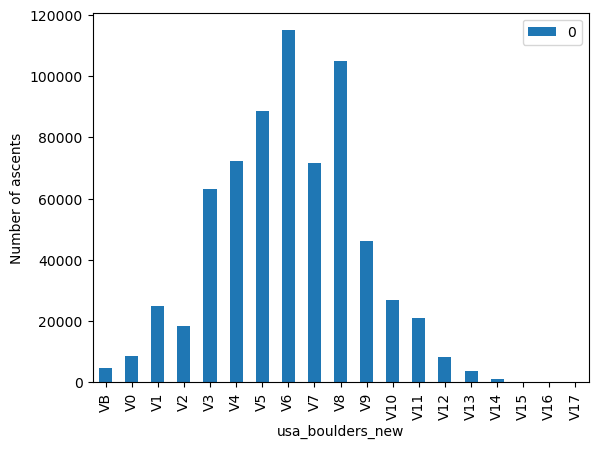

In [218]:
grades_order = ["VB", "V0", "V1", "V2", "V3", "V4", "V5", "V6", "V7", 
                "V8", "V9", "V10", "V11", "V12", "V13", "V14", "V15", "V16", "V17"]


grades_summary = pd.DataFrame(user_ascent_grade_method.groupby('usa_boulders_new').size())
grades_summary.index.name = 'usa_boulders_new'
grades_summary.reset_index(inplace=True)
grades_summary.set_index('usa_boulders_new').loc[grades_order].plot(kind="bar", ylabel="Number of ascents")

Most ascents logged in this dataset are in the V5-V8 range. These are difficult grades, suggesting the climbers in this dataset are high performing climbers.

How are these ascents completed? As a reminder, these are defintions of climbing methods in order of increasing difficulty:

- redpoint: completed after having practiced the route
- flash: completed on first try but have seen others compete or were told how to complete 
- onsight: completed first try without seeing how to complete or being told how to complete



name_methods
Flash       100725
Onsight      49795
Redpoint    528560
dtype: int64

<AxesSubplot:xlabel='name_methods', ylabel='Number of ascents'>

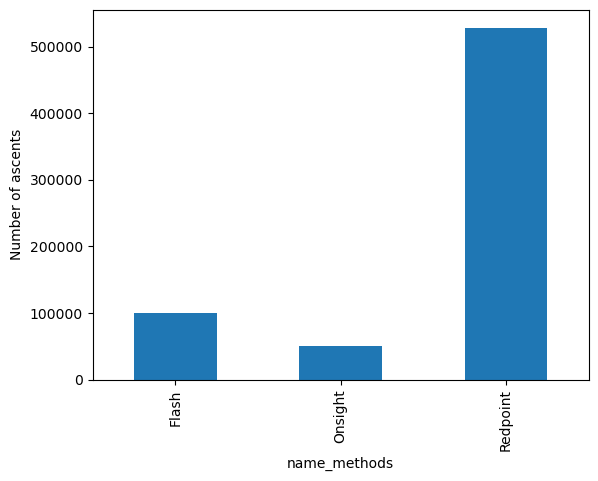

In [219]:
#remove any toprope climbs
user_ascent_grade_method = user_ascent_grade_method[user_ascent_grade_method['name_methods'].isin(
    ['Flash', 'Onsight', 'Redpoint'])]

methods_summary = user_ascent_grade_method.groupby('name_methods').size()
methods_summary
methods_summary.plot(kind='bar', ylabel="Number of ascents")

Not suprisingly the number of ascents per climbing method correspond to their respective difficulty. Onsights, the hardest type, was accomplished the least frequently, while redpoints, the easiest type, account for the overwhelming majority of ascents.

How is the dataset distributed by sex?

sex
0    7617
1     810
dtype: int64

<AxesSubplot:xlabel='sex', ylabel='Number of users'>

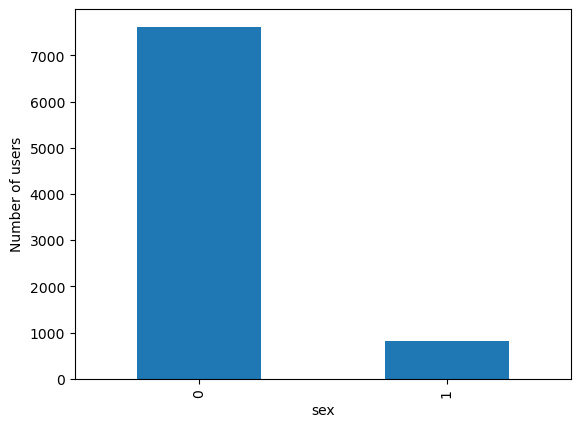

In [220]:
sex_distribution = user_ascent_grade_method.drop_duplicates(subset=['id_user']).groupby('sex').size()
sex_distribution
sex_distribution.plot(kind='bar', ylabel="Number of users")

There are many more males than females in this dataset. 
This will certainly bias the model. In the future, it would be great to identify a more representative dataset.

Where are the climbers from?

<AxesSubplot:xlabel='Country', ylabel='Number of climbers'>

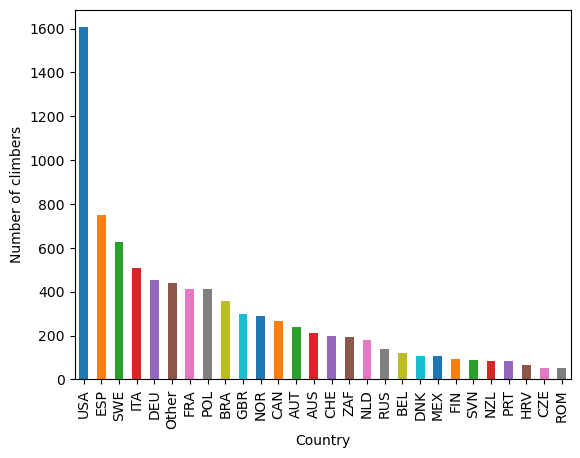

In [221]:
countries =  pd.DataFrame(user_ascent_grade_method.drop_duplicates(
    subset=['id_user']).groupby('country_user').size())

countries.index.name = 'country_user'
countries.reset_index(inplace=True)
countries = countries.rename(columns={countries.columns[1]: 'number_of_users'})

#combine countries with less than 10 into "other" category
countries['country_user'] = np.where(countries['number_of_users'] < 50, 
                                     'Other', countries['country_user'])

countries = countries.groupby('country_user')['number_of_users'].sum().sort_values(ascending=False)
cmap = plt.cm.tab10
colors = cmap(np.arange(len(countries)) % cmap.N)
countries.plot(kind='bar', color=colors, xlabel='Country', ylabel='Number of climbers' )

The US is the best represented county in the dataset, followed by countries mostly from Europe. The model will be biased towards climbers from North America and Europe. A more comprehensive dataset would produce a more representative model. 


I'll now identify the max grade completed per user. I'll also create a column with the date of the first time the max grade was completed (in the event a climber has multiple ascents at their max grade).

Going forward, I'm only interested in the ascents that occured before a climber completed their max grade, as I don't want data from the future to leak into my model.

In [222]:
#identify max grade completed per user
user_ascent_grade_method['max_grade'] = user_ascent_grade_method['usa_boulders_numeric'].groupby(
    user_ascent_grade_method['id_user']).transform('max')

#create column with date of first max grade ascent
user_ascent_grade_method['max_grade_date']=user_ascent_grade_method.sort_values(
    by=['usa_boulders_numeric', 'year'],ascending=[False, True]).groupby(
        'id_user')['year'].transform('first')

#remove any ascents that were completed after the max grade date 
user_ascent_grade_method = user_ascent_grade_method[user_ascent_grade_method['year'] <= user_ascent_grade_method['max_grade_date']]


Now I'm going to determine the years of experience, age, and number of ascents for each climber at the time they completed their max grade. 

In [223]:
user_ascent_grade_method['years_exp_max_grade']=user_ascent_grade_method.sort_values(
    by=['usa_boulders_numeric', 'year'],ascending=[False, True]).groupby(
        'id_user')['years_exp'].transform('first')

user_ascent_grade_method['age_max_grade']=user_ascent_grade_method.sort_values(
    by=['usa_boulders_numeric', 'year'],ascending=[False, True]).groupby(
        'id_user')['ascent_age'].transform('first')

user_ascent_grade_method['ascents_max_grade'] = user_ascent_grade_method.groupby(
    'id_user')['id_user'].transform('count')

I'll count the number of redpoints, flashes, and onsights for each climber. Each ascent can be cateogrized as one of these types.

In [224]:
ascent_type_sums = user_ascent_grade_method.pivot_table(
    values='ascent_count', index='user_id', columns='name_methods',
    fill_value=0, aggfunc='sum')

user_ascent_grade_method = pd.merge(user_ascent_grade_method, ascent_type_sums, on='user_id')

Now I will prepare the outcome variable for binary regression. My intitial testing showed that multinomial regression to predict each individual grade would not be feasible with this dataset, so I will condense the outcome categories into high and low based on the median max grade completed.

Median max grade: 8.0


<AxesSubplot:xlabel='Max Grade', ylabel='Number of climbers'>

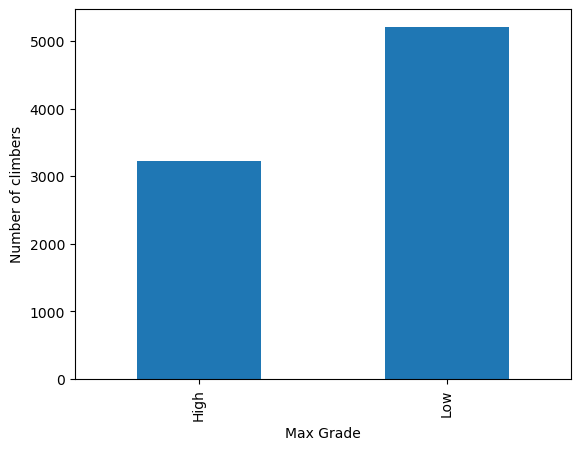

In [225]:
no_duplicate_users = user_ascent_grade_method.drop_duplicates(subset=['id_user'])

print("Median max grade:" ,np.median(no_duplicate_users['max_grade']))
no_duplicate_users['max_grade_combined'] = np.where(
    no_duplicate_users['max_grade'].isin([-1,0,1,2,3,4,5,6,7,8]), 'Low', 'High')

max_grade_summary = pd.DataFrame(no_duplicate_users.groupby('max_grade_combined').size())
max_grade_summary.index.name = 'max_grade_combined'
max_grade_summary.reset_index(inplace=True)

max_grade_summary.set_index('max_grade_combined').plot(
    kind='bar',xlabel='Max Grade', ylabel='Number of climbers', legend=None)

## Model building

The classes are not perfectly balanced, so I'll have to keep this in mind while evaluating the model. I'll now subset the data to the relevant features and convert the max grade outcome to an indicator variable.

In [227]:
input_df = no_duplicate_users[['id_user', 'sex', 'bmi', 'years_exp_max_grade', 
                               'age_max_grade', 'Redpoint', 'Onsight','Flash', 
                               'max_grade_combined']]


#High = 1
#Low =0 
input_df['max_grade_outcome'] = pd.get_dummies(
    input_df['max_grade_combined'])['High']

input_df.head(10)


x =input_df[['sex', 'bmi', 'years_exp_max_grade', 
             'age_max_grade', 'Redpoint', 'Onsight','Flash']]
y= input_df['max_grade_outcome']

,id_user,sex,bmi,years_exp_max_grade,age_max_grade,Redpoint,Onsight,Flash,max_grade_combined,max_grade_outcome
0,1,0,23.301095,6,26,1769,549,122,Low,0
40,3,0,24.074074,6,28,120,0,24,Low,0
52,10,0,22.589551,15,42,3486,664,332,Low,0
106,16,0,21.705129,15,38,4125,150,300,High,1
167,28,0,20.987654,25,41,59055,30099,24765,High,1
466,54,0,21.798202,8,30,52326,17442,8398,High,1
708,80,0,21.798202,6,25,460,0,69,Low,0
731,86,0,23.991213,10,28,441,0,0,Low,0
740,89,0,21.295295,22,40,8092,0,1785,High,1
823,110,0,23.836735,6,26,1173,0,51,Low,0


First, I'll assess if the data separates using an unsupervised analysis. 

<AxesSubplot:xlabel='principal component 1', ylabel='principal component 2'>

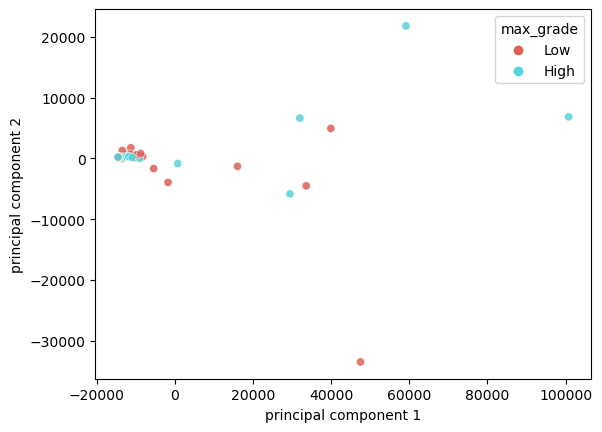

In [77]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

principal_df = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principal_df['max_grade'] = input_df['max_grade_combined']

sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="max_grade",
    palette=sns.color_palette("hls", 2),
    data=principal_df,
    legend="full",
    alpha=0.85
)

The data does not appear to separate by the maximum grade outcome on the first two components. I'll check if a supervised analysis performs better and can spearate climbers by these two groups.

My first choice algorthm is to use logistic regression since it provides explainable outcomes, so I will check if this algorithm is suitable.

There are 5 assumptions to check before using logistic regression:
- multicollinearity
- linearity
- outliers
- indepdence 
- binary outcome variable

I'll check check each of the features for multicollineraity using pearson's correlation.

<AxesSubplot:>

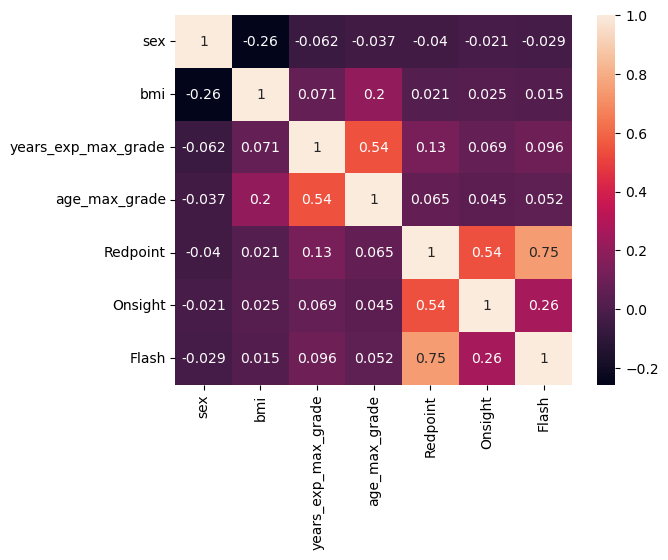

In [78]:
corr = x.corr()
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, annot=True)

The number of redpoints and flashes have a high correlation of +0.75, which would not work well with logistic regression.

Logistic regression also assumes features are indepdent of one another. In this dataset, the
features do not come from repeated mesaruremtns of the same feature over time, and they are independent of one another.

Logistic regression assumes the relationship between each continuous feature
and the logit of the outcome variable

<AxesSubplot:xlabel='age_max_grade', ylabel='max_grade_outcome'>

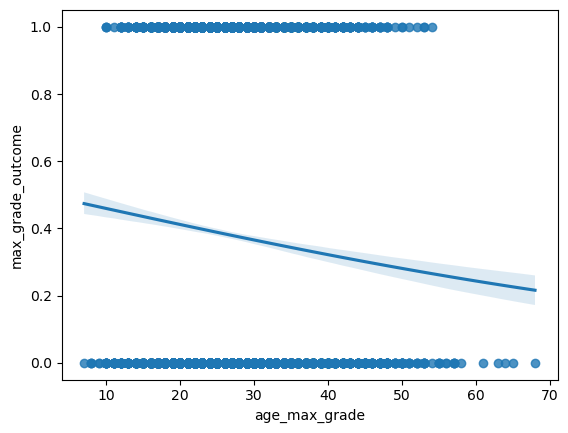

In [85]:
sns.regplot(x= input_df['age_max_grade'], y=input_df['max_grade_outcome'], logistic= True)


<AxesSubplot:xlabel='years_exp_max_grade', ylabel='max_grade_outcome'>

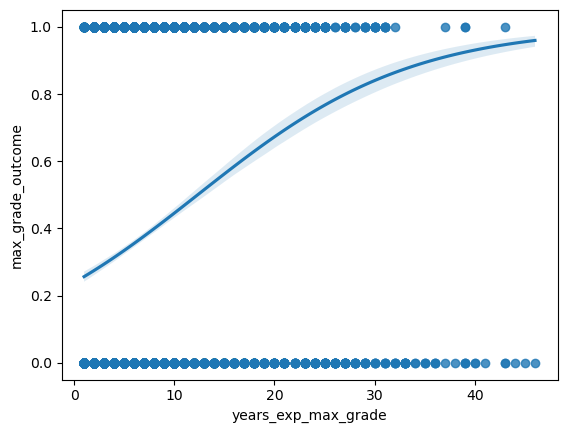

In [86]:
sns.regplot(x= input_df['years_exp_max_grade'], y=input_df['max_grade_outcome'], logistic= True)


<AxesSubplot:xlabel='bmi', ylabel='max_grade_outcome'>

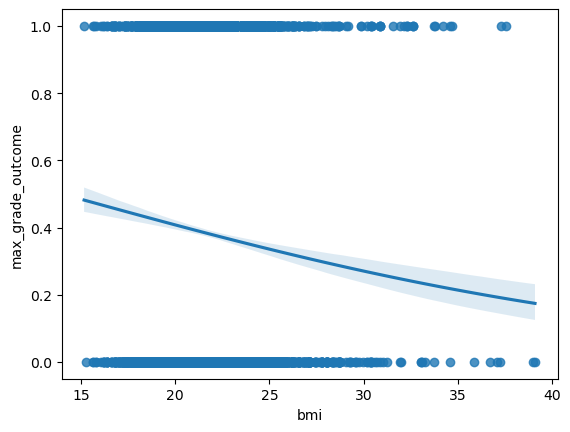

In [87]:
sns.regplot(x= input_df['bmi'], y=input_df['max_grade_outcome'], logistic= True)


<AxesSubplot:xlabel='Onsight', ylabel='max_grade_outcome'>

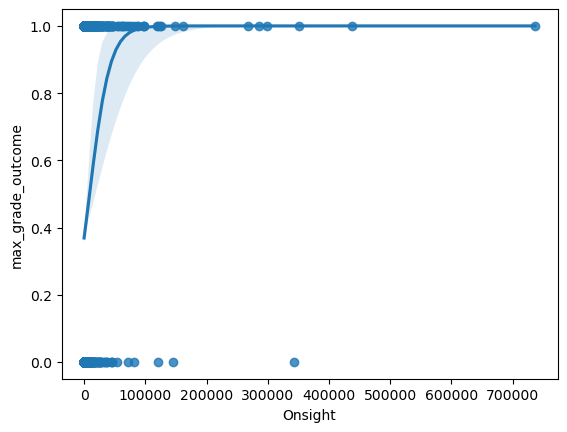

In [88]:
sns.regplot(x= input_df['Onsight'], y=input_df['max_grade_outcome'], logistic= True)


<AxesSubplot:xlabel='Flash', ylabel='max_grade_outcome'>

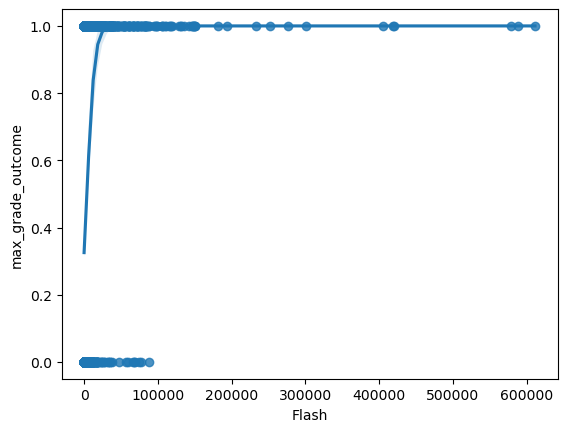

In [89]:
sns.regplot(x= input_df['Flash'], y=input_df['max_grade_outcome'], logistic= True)


While most of the features appear to meet this assumption, the number of flashes and onsights looks a little off. I will continue to test the other fewatures to see if logistic regression
is appropriate. 

Logistic regression does not work well with outliers. Let's check these features for outliers.

<AxesSubplot:>

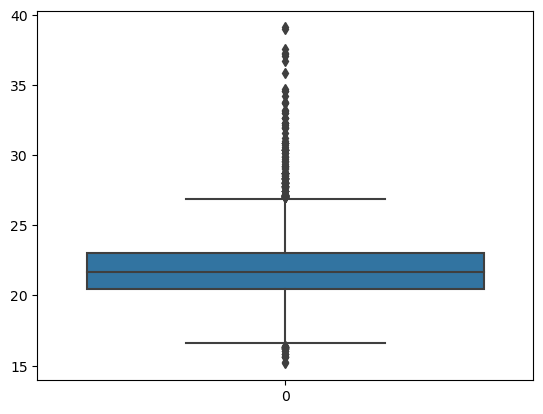

In [90]:
sns.boxplot(data= x['bmi'])


<AxesSubplot:>

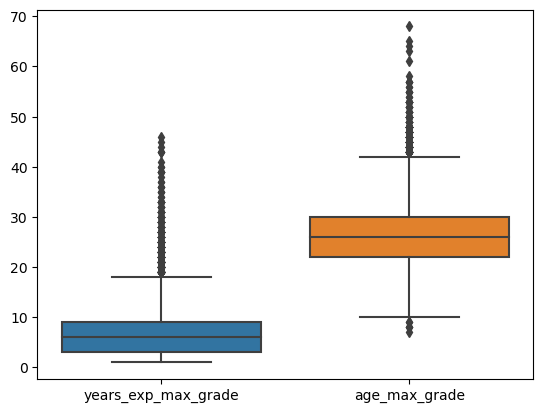

In [91]:
sns.boxplot(data= x[['years_exp_max_grade', 'age_max_grade']])


<AxesSubplot:>

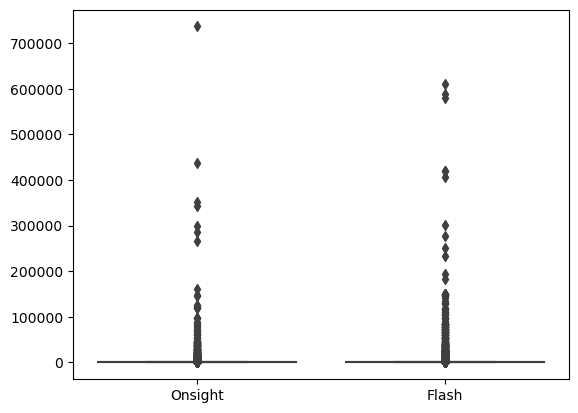

In [92]:
sns.boxplot(data= x[['Onsight', 'Flash']])

There are quite a few outliers across all of the categories with many of the features 
skewed toward higher values. Given that a few of the assumptions of logsitic regression have been violated, logistic regression is not the best algorithm for this analysis.

Instead, I will test svm, random forest, and xgboost models since they are more robust to outliers and mutlicollinearity, even though they these algorithms can have reduced feature explainability compared to  logistic regression

I'll first fit SVM models while tuning kernel type and regularization strength hyperameters. I'll leverage GridSearchCV to exhaustively check all parameter combinations.

In [ ]:
model = SVC()
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']

grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, cv=cv, scoring='accuracy',error_score=0)
grid_result_svm = grid_search.fit(x, y)

print("Best: %f using %s" % (grid_result_svm.best_score_, grid_result_svm.best_params_))
means = grid_result_svm.cv_results_['mean_test_score']
stds = grid_result_svm.cv_results_['std_test_score']
params = grid_result_svm.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Next, I'll check the performance of xgboost on this dataset across a range of parameters including n_estimators, learning_rate, subsample, and max_depth.

In [ ]:
model = XGBClassifier()
n_estimators = [10, 100, 1000]
learning_rate = [0.001, 0.01, 0.1]
subsample = [0.5, 0.7, 1.0]
max_depth = [3, 7, 9]

grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, cv=cv, scoring='accuracy',error_score=0)
grid_result_xgb = grid_search.fit(x, y)

print("Best: %f using %s" % (grid_result_xgb.best_score_, grid_result_xgb.best_params_))
means = grid_result_xgb.cv_results_['mean_test_score']
stds = grid_result_xgb.cv_results_['std_test_score']
params = grid_result_xgb.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Finally, I'll apply random forest while tuning n_estimators and max_features.

In [ ]:
model = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']

grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, cv=cv, scoring='accuracy',error_score=0)
grid_result_rf = grid_search.fit(x, y)

print("Best: %f using %s" % (grid_result_rf.best_score_, grid_result_rf.best_params_))
means = grid_result_rf.cv_results_['mean_test_score']
stds = grid_result_rf.cv_results_['std_test_score']
params = grid_result_rf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Now that the models have been built, I'll assess the classification accuracy across all algorithms and hyperparameters to determine which model performs best on this dataset.

In [ ]:
svm_accuracy = pd.DataFrame(grid_result_svm.cv_results_['mean_test_score'])
svm_accuracy['algorithm'] = 'SVM'

xgb_accuracy = pd.DataFrame(grid_result_xgb.cv_results_['mean_test_score'])
xgb_accuracy['algorithm'] = 'XGB'

rf_accuracy = pd.DataFrame(grid_result_rf.cv_results_['mean_test_score'])
rf_accuracy['algorithm'] = 'RF'

accuracy_comparison = pd.concat([svm_accuracy, xgb_accuracy, rf_accuracy])
accuracy_comparison = accuracy_comparison.rename(columns={accuracy_comparison.columns[0]: 'accuracy'})

accuracy_comparison.sort_values('accuracy', ascending=False).head(10)

sns.boxplot(data= accuracy_comparison, x='algorithm', y='accuracy')
sns.stripplot(data= accuracy_comparison, x='algorithm', y='accuracy', color='black',  alpha = 0.6)

xgboost is the best performing model at 80.1% accuracy and x parameters. SVM models show a wide range in performance across parameters, and the random forest model show accuracy that is just under xgboost. Let's fit an xgboost model using these optimized parameters and make some climbing performance predictions.

In [ ]:
#define model with best parameters
print(grid_result_xgb.best_params_)
best_xgb_model = grid_result_xgb.best_estimator_

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

#fit model and visualize feature importance
best_xgb_model.fit(x_train, y_train)
plot_importance(best_xgb_model)



These are the most important features.

In [ ]:
# Generate predictions with the best model
y_pred = best_xgb_model.predict(x_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


In the future, it would be great to identify more features that could improve accuracy, deploy this model in an application that tracks climbing stats and predicts maximum bouldering grade, as well as adjust to model from binary to multinomial regression make more informative predictions.